## Microproyecto 2 : Alcanzando los objetivos de desarrollo sostenible. Un aporte desde el machine learning

El objetivo de este microproyecto 2 es desarrollar una solución, basada en técnicas de procesamiento de lenguaje natural y machine learning, que facilite la interpretación y análisis de información textual para la identificación
de relaciones semánticas con los Objetivos de Desarrollo Sostenibles.
Los textos de este proyecto han sido traducidos al español mediante herramientas como `Deepl2`. También se realizó una aumentación de textos a través del API de `ChatGPT3`

### 1. Importacion de librerias

In [34]:
import pandas as pd
import os
import sys
import numpy as np
from typing import List
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import re
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from nltk.stem.porter import PorterStemmer
import plotly.express as px
import plotly.io as pio
from nltk import RegexpTokenizer, word_tokenize
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import time

In [ ]:
# Se descargan stopwords, el tokenizador punkt y el modelo de spaCy en español
nltk.download('punkt_tab')
!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")
nltk.download('stopwords')

# Suprimir warnings comprehensivos
import warnings
import os

# Suprimir todas las advertencias generales
warnings.filterwarnings('ignore')

# Suprimir específicamente advertencias de pkg_resources
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

# Configurar variable de entorno para evitar el warning de pkg_resources
os.environ['PYTHONWARNINGS'] = 'ignore::UserWarning:pkg_resources'

# Para multiprocessing específicamente
import multiprocessing
if hasattr(multiprocessing, 'set_start_method'):
    try:
        multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/antonio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.6 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Cargar datos

In [36]:
data = pd.read_excel('data/Train_textosODS.xlsx')
data.head()

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


In [37]:
data.shape

(9656, 2)

In [38]:
data.duplicated().sum()

np.int64(0)

In [39]:
data.isna().sum()

textos    0
ODS       0
dtype: int64

In [40]:
data.ODS.value_counts()

ODS
16    1080
5     1070
4     1025
3      894
7      787
6      695
11     607
1      505
13     464
8      446
14     377
2      369
10     352
9      343
15     330
12     312
Name: count, dtype: int64

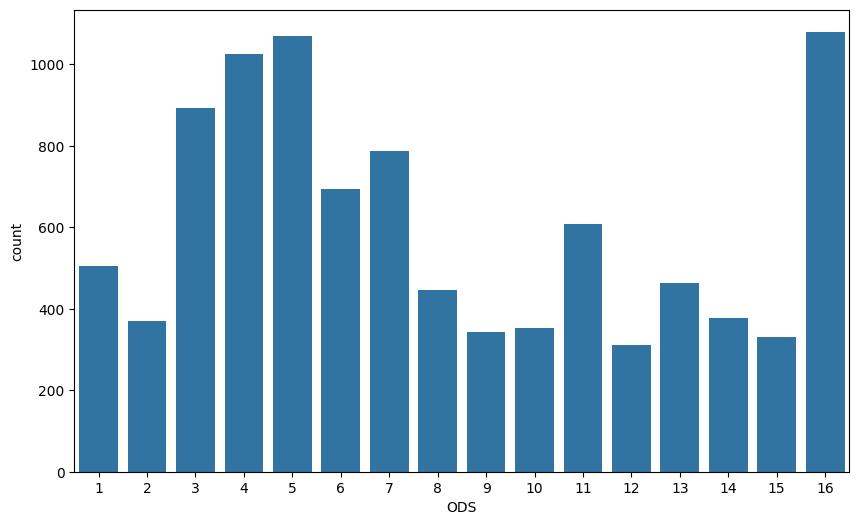

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='ODS')
plt.show()

Se nota que las clases estan desbalanceadas

Division de los datos en entrenamiento y pruebas

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data['textos'], data['ODS'], test_size=0.3, random_state=42, stratify=data['ODS'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6759,), (2897,), (6759,), (2897,))

### 3. Limpienza y exploración de los datos

In [43]:
#tokenizacion por palabras
def text_preprocess(texto, stemming=True):

  ''' Preprocesa el texto: tokenizacion, stop words y stemming
      Input: texto (str)
      Output: texto preprocesado (str)'''
      
  tokenizer = RegexpTokenizer(r'\w+')
  stemmer = PorterStemmer()
  #stop words
  stop_words = set(stopwords.words('spanish'))
  tokens = texto.lower()
  tokens = tokenizer.tokenize(tokens)
  tokens = [word for word in tokens if word not in stop_words]
  if stemming:
      tokens = ' '.join([stemmer.stem(word) for word in tokens])
  else:
      tokens = ' '.join(tokens)
  return tokens

In [44]:
processed_texts = [text_preprocess(texto, stemming=False) for texto in data['textos']]
wc_text = ' '.join(processed_texts)

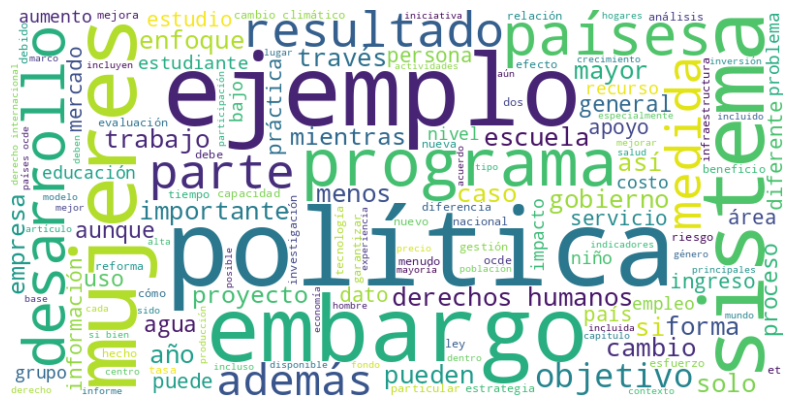

In [45]:
# Create WordCloud instance
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color ='white',
    min_font_size=10,
    max_font_size=110
).generate(wc_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
# Función para crear matriz de confusión

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    Crea y muestra una matriz de confusión
    
    Parameters:
    -----------
    y_true : array-like
        Valores reales
    y_pred : array-like  
        Predicciones del modelo
    cmap : matplotlib colormap
        Esquema de colores para el heatmap
    figsize : tuple
        Tamaño de la figura
    """
    # Crear matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Obtener las clases únicas
    classes = sorted(y_true.unique())
    
    # Crear la figura
    plt.figure(figsize=figsize)
    
    # Crear heatmap
    sns.heatmap(cm, 
                annot=True,           
                fmt='d',              
                cmap=cmap,   
                xticklabels=classes,  
                yticklabels=classes,  
                cbar_kws={'label': 'Número de muestras'})
    
    # Configurar etiquetas y título
    plt.title('Matriz de Confusión - Clasificación ODS', fontsize=16, pad=20)
    plt.xlabel('Predicción', fontsize=14)
    plt.ylabel('Valor Real', fontsize=14)
    
    # Rotar etiquetas si hay muchas clases
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()
    
    # Imprimir accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    return cm

Ejemplo de texto orginal y preprocesado

In [47]:
print(data['textos'][0])
print(text_preprocess(data['textos'][0]))

"Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.
aprendizaj educación consideran sinónimo escolarización formal organizacion auxiliar editorial educación junta examinadora organizacion formación docent consideran extension acuerdo establecido gobierno marco comprensión vuelto cada vez inadecuado


### 3. Creacion de modelo base con pipeline

Se usa `TfidfVectorizer`para la vecotrizacion del texto que luego sera procesado por los diferentes algortimos.

In [ ]:
# Vectorizacion con TF-IDF
tfidf = TfidfVectorizer(preprocessor=text_preprocess, smooth_idf=True)
#Reduccion de dimensionalidad. No se usa PCA por que nos generaria una matriz dispersa
tsvd = TruncatedSVD(n_components=50, n_iter=10)

In [23]:
Count_vect = CountVectorizer(preprocessor=text_preprocess)
lda = LatentDirichletAllocation(n_components=50, random_state=42)

In [24]:
logreg = LogisticRegression(random_state=42)

In [25]:
steps = [('vectorize', Count_vect),
        ('lda', lda),        
        ('logreg', logreg)]

In [ ]:
params_grid = {'lda__n_components': [20, 40, 60, 80],
               'logreg__C': [0.1, 0.5, 1, 4, 10],
               'logreg__class_weight': ['balanced', None]
            }


In [27]:
pipeline = Pipeline(steps=steps)

In [30]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=params_grid, cv=kfold, verbose=3)

In [31]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=balanced;, score=0.477 total time=  23.8s
[CV 2/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=balanced;, score=0.484 total time=  23.8s
[CV 3/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=balanced;, score=0.507 total time=  23.8s
[CV 4/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=balanced;, score=0.484 total time=  23.4s
[CV 5/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=balanced;, score=0.510 total time=  23.4s
[CV 1/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=None;, score=0.483 total time=  23.1s
[CV 2/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=None;, score=0.485 total time=  23.4s
[CV 3/5] END lda__n_components=10, logreg__C=0.1, logreg__class_weight=None;, score=0.490 total time=  23.9s
[CV 4/5] END lda__n_components=10, logreg__C=0

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lda__n_components': [10, 20, ...], 'logreg__C': [0.1, 0.5, ...], 'logreg__class_weight': ['balanced', None]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [31]:
grid.best_params_

{'logreg__C': 10, 'logreg__class_weight': None, 'tsvd__n_components': 40}

### 4. Evaluacion de resultados con datos reales

In [32]:
y_pred = grid.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.49      0.68      0.57       151
           2       0.53      0.46      0.49       111
           3       0.77      0.83      0.80       268
           4       0.86      0.90      0.88       308
           5       0.72      0.82      0.76       321
           6       0.78      0.84      0.81       208
           7       0.68      0.90      0.77       236
           8       0.46      0.36      0.40       134
           9       0.50      0.17      0.26       103
          10       0.42      0.15      0.22       106
          11       0.56      0.51      0.53       182
          12       0.51      0.45      0.48        94
          13       0.67      0.69      0.68       139
          14       0.64      0.50      0.56       113
          15       0.69      0.33      0.45        99
          16       0.84      0.97      0.90       324

    accuracy                           0.70      2897
   macro avg       0.63   

#### 5. Busqueda de hiperparamentros 

`spaCy` es una libreria para el procesamiento del lenguaje natural de codigo abierto implemetada en Python. Es rapida, eficiente y facil de usar ademas de funcionar bien para el idioma español.
Entre sus catracteristicas podemos destacar:

- Analisis sintactico y sementico
- Reconocimiento de entidades nombradas
- Lemmatizacion y tokenizacion 
- Analisis de dependencias
- Modelos preentrenados en español

In [17]:
# 5. VISUALIZAR RESULTADOS
def show_results(results):
    """
    Visualiza la comparación entre modelos
    """
    if not results:
        print("No hay resultados para visualizar")
        return
    
    # Crear DataFrame con métricas
    metricas_df = pd.DataFrame({
        'Modelo': list(results.keys()),
        'Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
        'F1-Score': [results[m]['test_f1'] for m in results.keys()],
        'Precision': [results[m]['test_precision'] for m in results.keys()],
        'Recall': [results[m]['test_recall'] for m in results.keys()],
        'Tiempo (s)': [results[m]['training_time'] for m in results.keys()]
    })
    
    print("=== RESUMEN DE RESULTADOS ===")
    print(metricas_df.round(4))
    
    # Gráfico de barras para métricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0,0].bar(metricas_df['Modelo'], metricas_df['Accuracy'], color='skyblue')
    axes[0,0].set_title('Accuracy por Modelo')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # F1-Score
    axes[0,1].bar(metricas_df['Modelo'], metricas_df['F1-Score'], color='lightgreen')
    axes[0,1].set_title('F1-Score por Modelo')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Precision
    axes[1,0].bar(metricas_df['Modelo'], metricas_df['Precision'], color='orange')
    axes[1,0].set_title('Precision por Modelo')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Tiempo de entrenamiento
    axes[1,1].bar(metricas_df['Modelo'], metricas_df['Tiempo (s)'], color='salmon')
    axes[1,1].set_title('Tiempo de Entrenamiento')
    axes[1,1].set_ylabel('Tiempo (segundos)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Ranking de modelos
    print("\n=== RANKING DE MODELOS ===")
    ranking = metricas_df.sort_values('F1-Score', ascending=False)
    for i, (_, row) in enumerate(ranking.iterrows(), 1):
        print(f"{i}. {row['Modelo']}: F1={row['F1-Score']:.4f}, Accuracy={row['Accuracy']:.4f}")
    
    return metricas_df

In [18]:
# 6. ANÁLISIS DETALLADO DEL MEJOR MODELO
def best_model_analyze(resultados):
    """
    Analiza en detalle el mejor modelo
    """
    if not resultados:
        return
    
    # Encontrar el mejor modelo por F1-Score
    best_model_name = max(resultados.keys(), 
                             key=lambda k: resultados[k]['test_f1'])
    best_model = resultados[best_model_name]
    
    print(f"=== ANÁLISIS DEL MEJOR MODELO: {best_model_name} ===")
    print(f"F1-Score: {best_model['test_f1']:.4f}")
    print(f"Accuracy: {best_model['test_accuracy']:.4f}")
    print(f"Precision: {best_model['test_precision']:.4f}")
    print(f"Recall: {best_model['test_recall']:.4f}")
    print(f"Tiempo de entrenamiento: {best_model['training_time']:.2f}s")
    print(f"\nMejores hiperparámetros:")
    for param, value in best_model['best_params'].items():
        print(f"  {param}: {value}")
    
    # Matriz de confusión del mejor modelo
    print(f"\n=== MATRIZ DE CONFUSIÓN - {best_model_name} ===")
    cm = plot_confusion_matrix(y_test, best_model['predictions'])
    
    # Reporte de clasificación
    print(f"\n=== REPORTE DE CLASIFICACIÓN - {best_model_name} ===")
    print(classification_report(y_test, best_model['predictions']))

    return best_model_name, best_model

In [19]:
def test_model(model, texto, ods_esperado):
    """
    Prueba un modelo específico con texto personalizado
    """
    prediccion = model.predict([texto])[0]
    if model.predict_proba is not None:
        probabilidades = model.predict_proba([texto])[0]
        confianza = np.max(probabilidades)
        
        print(f"Predicción: ODS {prediccion}")
        print(f"Confianza: {confianza:.3f}")
        print(f"Texto: {texto[:100]}...")
    else:
        print(f"Predicción: ODS {prediccion}")
        print(f"Texto: {texto[:100]}...")
    print(f"Correcta: {'✅' if prediccion == ods_esperado else '❌'}")
    print("-" * 80)

In [20]:
def preprocess_spacy_single(text):
    """
    Preprocesamiento para un solo texto
    """
    try:
        if not isinstance(text, str):
            text = str(text)
        
        doc = nlp(text)  # Para un solo texto, usa nlp() directamente
        
        tokens = []
        for token in doc:
            if (not token.is_stop and 
                not token.is_punct and 
                not token.is_space and
                token.pos_ in ['NOUN', 'VERB', 'ADJ', 'PROPN']):
                
                lemma = token.lemma_.lower()
                if lemma not in ['ser', 'estar', 'tener', 'hacer', 'dar', 'ir', 'ver']:
                    tokens.append(lemma)
        
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error: {e}")
        return str(text)

In [21]:
# Preprocesamiento con Spacy
def preprocess_spacy_batch(texts: List[str]) -> List[str]:
    """
    Preprocesamiento optimizado para clasificación de ODS - para múltiples textos
    """
    processed_texts = []
    
    try:
        # Usar nlp.pipe para procesar múltiples textos eficientemente
        for doc in nlp.pipe(texts, batch_size=128):
            tokens = []
            for token in doc:
                # Filtrar tokens relevantes
                if (not token.is_stop and 
                    not token.is_punct and 
                    not token.is_space and
                    token.pos_ in ['NOUN', 'VERB', 'ADJ', 'PROPN']):  # Incluir nombres propios
                    
                    # Usar lemma en minúsculas
                    lemma = token.lemma_.lower()
                    
                    # Filtrar palabras muy comunes que no aportan
                    if lemma not in ['ser', 'estar', 'tener', 'hacer', 'dar', 'ir', 'ver']:
                        tokens.append(lemma)
            
            processed_texts.append(' '.join(tokens))
    except Exception as e:
        print(f"Error en el procesamiento por lotes: {e}")
        return [str(text) for text in texts]

    return processed_texts

In [22]:
print(data['textos'][1])
preprocess_spacy_batch([data['textos'][1]])

No dejar clara la naturaleza de estos riesgos puede dar lugar a un exceso de inversión en empresas dependientes del agua y a peticiones de compensación cuando haya que reducir los derechos para evitar comprometer la calidad del agua y otros resultados medioambientales. Por ejemplo, es fundamental evitar cualquier escasez en la disponibilidad de agua para la refrigeración de centrales nucleares, ya que las consecuencias son inaceptablemente elevadas. Sin embargo, los agricultores que se dedican a cultivos anuales de escaso valor pueden estar dispuestos a renunciar al uso del agua en épocas de escasez, especialmente si pueden recuperar un mayor valor comerciando con sus derechos de agua para usos de mayor valor que el que pueden recuperar utilizando el agua. Los distintos usuarios del agua también tienen diferentes capacidades para gestionar el riesgo de escasez de agua dulce, mejorando la eficiencia, recurriendo a fuentes de agua alternativas o ajustando el calendario de su uso del agua

['dejar claro naturaleza riesgo lugar exceso inversión empresa dependiente agua petición compensación reducir derecho evitar comprometer calidad agua resultado medioambiental ejemplo fundamental evitar escasez disponibilidad agua refrigeración central nuclear consecuencia elevado agricultor dedicar cultivo anual escaso valor dispuesto renunciar agua época escasez recuperar valor comerciar derecho agua uso valor recuperar utilizar agua usuario agua capacidad gestionar riesgo escasez agua dulce mejorar eficiencia recurrir fuente agua alternativo ajustar calendario agua']

In [23]:
class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, model='es_core_news_sm'):
        self.model = model
        self.nlp = spacy.load(model)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Use preprocess_spacy_single for individual texts (fixes the bug)
        return [' '.join([token.lemma_ for token in self.nlp(text) 
                        if not token.is_stop and not token.is_punct and token.is_alpha])
                        for text in X]
    
    # Hacer la clase serializable
    def __getstate__(self):
        state = self.__dict__.copy()
        # Remover el objeto nlp que no es serializable
        if 'nlp' in state:
            del state['nlp']
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)
        # Recrear el objeto nlp al deserializar
        self.nlp = spacy.load(self.model)

In [24]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """Transformer personalizado para preprocessing de texto"""
    
    def __init__(self, method='nltk'):
        self.method = method
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.method == 'nltk':
            return [text_preprocess(text) for text in X]
        elif self.method == 'spacy':
            # Use preprocess_spacy_single for individual texts (fixes the bug)
            return [preprocess_spacy_single(text) for text in X]
        else:
            return list(X)

In [26]:
def pipeline_creator(models):
    '''Crear pipelines para una lista de modelos'''
    pipelines = {}
    for model in models:
        model_name = model.__class__.__name__
        if model_name == 'MultinomialNB':
            # Para MultinomialNB: sin TruncatedSVD (que puede generar valores negativos)
            pipelines[model_name] = Pipeline([
                #('preprocessor', SpacyPreprocessor()),  # El prepoceso en el pipeline demora mucho
                ('vectoriser', TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=2, 
                                               max_features=50_000)),
                ('selector', SelectKBest(score_func=f_classif, k=2000)),
                #('dim_reducer', TruncatedSVD(n_components=100, random_state=42)),
                ('clf', model)
            ])
        else:
            # Para otros modelos: pipeline completo
            pipelines[model_name] = Pipeline([
                #('preprocessor', SpacyPreprocessor()),  # Paso de preprocessing
                ('vectoriser', TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=2, max_features=50_000)),
                #('selector', SelectKBest(score_func=f_classif, k=2000)),
                ('dim_reducer', TruncatedSVD(n_components=100, random_state=42)),
                ('clf', model)
            ])
    return pipelines

def params_grid_creator(model_name):
    '''Crear grids de parametros para cada modelo'''
    if model_name == 'LogisticRegression':
        params_grid = {'dim_reducer__n_components': [50, 100, 150],
                       'clf__C': [0.1, 1, 10],
                       'clf__solver': ['lbfgs', 'saga']
                      }
    elif model_name == 'MultinomialNB':
        params_grid = {'selector__k': [1000, 1500, 2000],
                       'clf__alpha': [0.1, 1.0, 10.0]
                      }
    elif model_name == 'RandomForestClassifier':
        params_grid = {'dim_reducer__n_components': [50, 100, 150],
                       'clf__n_estimators': [100, 150, 200],
                       'clf__max_depth': [10, 20, 50]
                      }
    elif model_name == 'SVC':
        params_grid = {#'selector__k': [1000, 2000],
                       'dim_reducer__n_components': [50, 100, 150],
                       'clf__C': [0.1, 1, 10],
                       'clf__kernel': ['rbf', 'linear']
                      }
    else:
        raise ValueError(f"Modelo {model_name} no soportado")
    
    return params_grid  

In [27]:
def models_comparison(models, X_train_processed, y_train, X_test_processed, y_test):
    '''Comparar modelos con GridSearchCV'''
    pipelines = pipeline_creator(models)
    results = {}
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


    for model_name, pipeline in pipelines.items():
        print(f"Entrenando modelo: {model_name}")
        start_time = time.time()
        params_grid = params_grid_creator(model_name)
        grid_search = GridSearchCV(pipeline, param_grid=params_grid, cv=kfold, verbose=3, n_jobs=-1)
        grid_search.fit(X_train_processed, y_train)
        end_time = time.time()
        train_time = end_time - start_time
        print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
        y_pred = grid_search.predict(X_test_processed)
        y_pred_proba = grid_search.predict_proba(X_test_processed) if hasattr(grid_search, 'predict_proba') else None
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        
        # Guardar resultados
        results[model_name] = {
            'model': grid_search,            
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'test_accuracy': accuracy,
            'test_f1': f1,
            'test_precision': precision,
            'test_recall': recall,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'training_time': train_time
            }
        print(f"   {model_name} completado")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   Tiempo: {train_time:.2f}s")
        print(f"   Mejores parámetros: {grid_search.best_params_}")
        print("-" * 60)
    return results

Dividir los datos nuevamente y preprocesarlos

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data['textos'], data['ODS'], test_size=0.3, random_state=42, stratify=data['ODS'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6759,) (2897,) (6759,) (2897,)


In [29]:
# Usar la función batch para mejor rendimiento
print("Preprocesando datos de entrenamiento...")
X_train_processed = preprocess_spacy_batch(X_train)
print("Preprocesando datos de prueba...")
X_test_processed = preprocess_spacy_batch(X_test)

Preprocesando datos de entrenamiento...
Preprocesando datos de prueba...


In [ ]:
# 4. EJECUTAR LA COMPARACIÓN

print("Iniciando comparación de modelos...")
models = [LogisticRegression(random_state=42, multi_class='multinomial', class_weight='balanced'), 
          RandomForestClassifier(random_state=42, class_weight='balanced'), 
          SVC(probability=True, random_state=42, class_weight='balanced'),
          MultinomialNB()]
models_results = models_comparison(models, X_train, y_train, X_test, y_test)

Iniciando comparación de modelos...
Entrenando modelo: LogisticRegression
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV 3/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=50;, score=0.795 total time=  14.4s
[CV 1/5] END clf__C=0.1, clf__solver=saga, dim_reducer__n_components=50;, score=0.809 total time=  14.8s
[CV 2/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=50;, score=0.813 total time=  15.4s
[CV 5/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=50;, score=0.810 total time=  15.7s
[CV 1/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=50;, score=0.811 total time=  15.8s
[CV 4/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=50;, score=0.811 total time=  15.9s
[CV 2/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=100;, score=0.834 total time=  24.7s
[CV 4/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=100;, score=0.815 total time=  26.4s
[CV 3/5] END clf__C=0.1, clf__solver=lbfgs, dim_reducer__n_components=100;, score=0.814 total time=  26.4s
[CV 5/5] END clf__C=0.1, clf__solver=lbfgs, 

=== RESUMEN DE RESULTADOS ===
                   Modelo  Accuracy  F1-Score  Precision  Recall  Tiempo (s)
0      LogisticRegression    0.8654    0.8671     0.8705  0.8654     71.3386
1  RandomForestClassifier    0.8371    0.8356     0.8377  0.8371     75.2525
2                     SVC    0.8740    0.8736     0.8744  0.8740     88.3979
3           MultinomialNB    0.8616    0.8553     0.8630  0.8616      8.3669


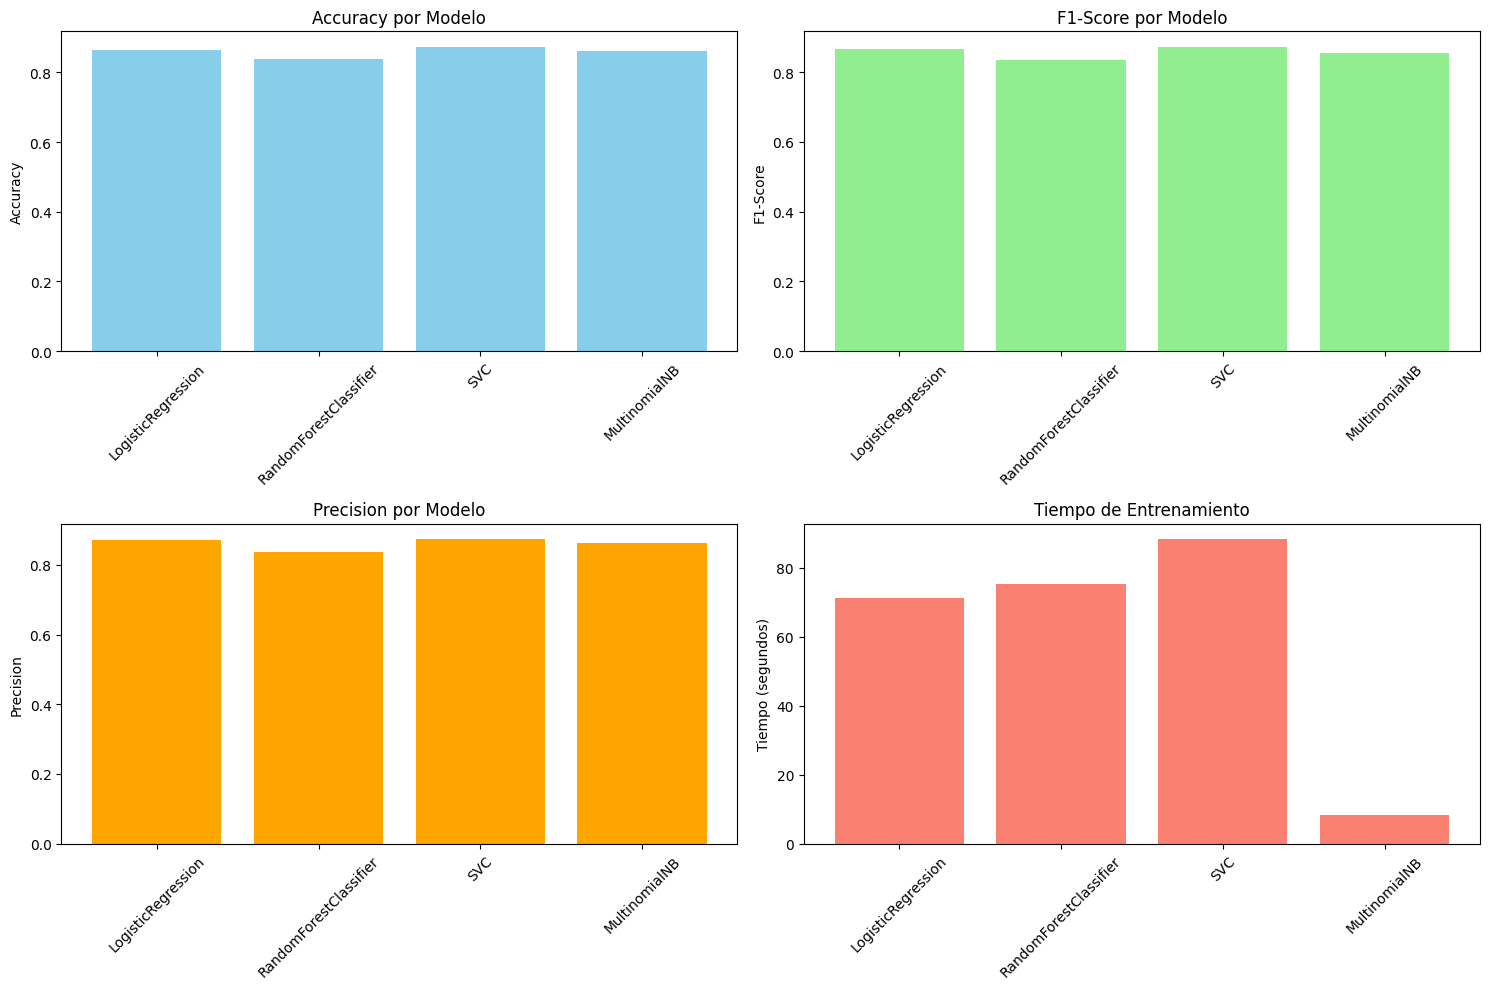


=== RANKING DE MODELOS ===
1. SVC: F1=0.8736, Accuracy=0.8740
2. LogisticRegression: F1=0.8671, Accuracy=0.8654
3. MultinomialNB: F1=0.8553, Accuracy=0.8616
4. RandomForestClassifier: F1=0.8356, Accuracy=0.8371
=== ANÁLISIS DEL MEJOR MODELO: SVC ===
F1-Score: 0.8736
Accuracy: 0.8740
Precision: 0.8744
Recall: 0.8740
Tiempo de entrenamiento: 88.40s

Mejores hiperparámetros:
  clf__C: 10
  clf__kernel: rbf
  dim_reducer__n_components: 100

=== MATRIZ DE CONFUSIÓN - SVC ===


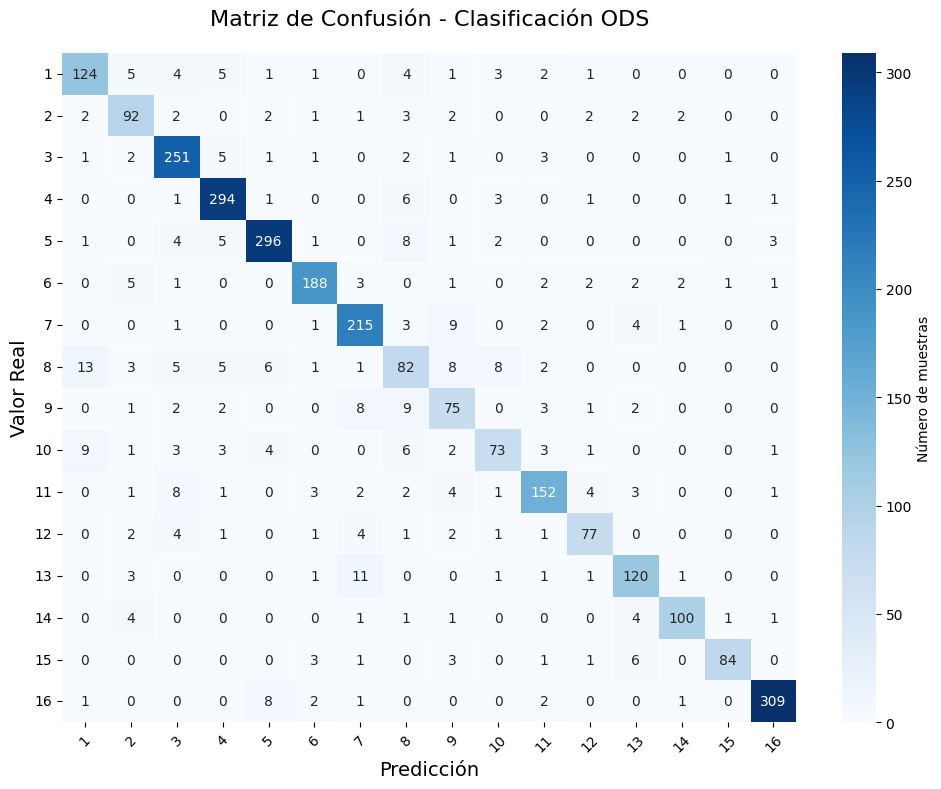


Accuracy: 0.8740 (87.40%)

=== REPORTE DE CLASIFICACIÓN - SVC ===
              precision    recall  f1-score   support

           1       0.82      0.82      0.82       151
           2       0.77      0.83      0.80       111
           3       0.88      0.94      0.91       268
           4       0.92      0.95      0.93       308
           5       0.93      0.92      0.93       321
           6       0.92      0.90      0.91       208
           7       0.87      0.91      0.89       236
           8       0.65      0.61      0.63       134
           9       0.68      0.73      0.70       103
          10       0.79      0.69      0.74       106
          11       0.87      0.84      0.85       182
          12       0.85      0.82      0.83        94
          13       0.84      0.86      0.85       139
          14       0.93      0.88      0.91       113
          15       0.95      0.85      0.90        99
          16       0.97      0.95      0.96       324

    accuracy 

In [ ]:
show_results(models_results)
best_model_name, best_model = best_model_analyze(models_results)

### 6. Evaluacion del modelo

Evaluacion del mejor modelo entrenado con datos nuevos generados aleatoriamente mediante chatgpt

In [97]:
# Reemplazar la celda que da error

# Generar textos de prueba para diferentes ODS
textos_prueba = {
    1: "La erradicación de la pobreza extrema es fundamental para el desarrollo sostenible. Necesitamos programas de asistencia social, microcréditos y oportunidades de empleo digno para las poblaciones más vulnerables.",
    
    2: "La seguridad alimentaria requiere agricultura sostenible, mejores técnicas de cultivo y acceso equitativo a alimentos nutritivos. La malnutrición infantil debe ser prioridad.",
    
    3: "Los sistemas de salud deben ser universales y accesibles. La prevención de enfermedades, vacunación masiva y atención médica de calidad son derechos fundamentales.",
    
    4: "La educación de calidad debe ser inclusiva y equitativa. Necesitamos inversión en infraestructura educativa, formación docente y acceso a tecnologías.",
    
    5: "La igualdad de género implica eliminar la discriminación, promover el liderazgo femenino y garantizar igualdad de oportunidades en todos los ámbitos.",
    
    13: "El cambio climático requiere acciones urgentes. Debemos reducir emisiones de carbono, promover energías renovables y adaptarnos a los impactos climáticos.",
    
    16: "Las instituciones sólidas y la justicia son pilares de la democracia. Necesitamos transparencia, rendición de cuentas y Estado de derecho."
}

# Probar el modelo con diferentes textos
print("=== PRUEBAS DEL MODELO ===\n")
model = best_model['model']

for ods_esperado, texto in textos_prueba.items():
    # Predecir con el modelo
    texto_preprocesado = preprocess_spacy_single(texto)  # Asegurarse de que el texto se preprocese correctamente
    test_model(model, texto_preprocesado, ods_esperado)

=== PRUEBAS DEL MODELO ===

Predicción: ODS 1
Confianza: 0.858
Texto: erradicación pobreza extremo fundamental desarrollo sostenible necesitar programa asistencia social ...
Correcta: ✅
--------------------------------------------------------------------------------
Predicción: ODS 2
Confianza: 0.992
Texto: seguridad alimentario requerir agricultura sostenible mejor técnica cultivo acceso equitativo alimen...
Correcta: ✅
--------------------------------------------------------------------------------
Predicción: ODS 3
Confianza: 0.999
Texto: sistema salud universal accesibl prevención enfermedad vacunación masivo atención médico calidad der...
Correcta: ✅
--------------------------------------------------------------------------------
Predicción: ODS 4
Confianza: 0.974
Texto: educación calidad inclusivo equitativo necesitar inversión infraestructura educativo formación docen...
Correcta: ✅
--------------------------------------------------------------------------------
Predicción: ODS 